Emilia Stefanowska, 2024

# [1] Opis zadania

Problem klasyfikacji polega na rozpoznawaniu **napadów padaczkowych** na podstawie cech zapisu EEG (cech szeregu czasowego).
Stany (etykiety) : **normalny (0), międzynapadowy (2), napad (1)**.

Dane: 783 cechy szeregów czasowych – problem wieloklasowy

W rozwiązaniu znajduje się:
- zastosowanie algorytmu FRESH do wstępnej selekcji cech oraz sprawdzenie poprawności
selekcji z wykorzystaniem RFE,
- zastosowanie korelacji do ograniczenia danych do 30 cech,
- zastosowanie algorytmu lasu lasowego do ograniczenia zbioru do 7 cech
uwzględnieniem analizy korelacji między cechami,
- wstępna klasyfikacja z zastosowaniem sieci neuronowej na podstawie 7 cech
- zastosowanie metody shap.KernelExplainer (analiza zbiorcza, analiza
każdej z klas, analiza jednej wybranej cechy dla każdej z klas) – pełna interpretacja
modelu oraz selekcja cech,
- klasyfikacja na podstawie wybranych trzech cech za pomocą sieci neuronowej,
- dostrojenie hiperparametrów oraz ocena krzywych uczenia,
- wnioski


# [2] Import bibliotek

In [ ]:
!pip install -q tsfresh
!pip install -q pingouin
!pip install -q torchmetrics
!pip install -q captum
! pip install -q shap
import pandas as pd
import numpy as np
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
import random as random
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from typing import Tuple, List
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report
import captum
from captum.attr import FeaturePermutation
import shap
from shap import KernelExplainer

# [3] Przygotowanie danych

In [ ]:
# Nasionko :)
seed_value = 24

np.random.seed(seed_value)
random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True

# Przygotowanie danych
df = pd.read_csv('wszystkie_cechy.csv')

# Pozbywamy się class (etykiety)
extracted_features = df.drop(['class'], axis=1)

# Zamienie NaN na zera
extracted_features = impute(extracted_features)

# I przygotuwujemy Series z etykietami
y = df['class']

The columns ['measurements__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.


In [ ]:
# Zobaczmy co jest w środku
extracted_features

measurements__variance_larger_than_standard_deviation  \
0                                                  1.0       
1                                                  1.0       
2                                                  1.0       
3                                                  1.0       
4                                                  1.0       
..                                                 ...       
495                                                1.0       
496                                                1.0       
497                                                1.0       
498                                                1.0       
499                                                1.0       

     measurements__has_duplicate_max  measurements__has_duplicate_min  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
..                               ...                              ...   
495                              0.0                              0.0   
496                              0.0                              0.0   
497                              0.0                              0.0   
498                              0.0                              0.0   
499                              0.0                              0.0   

     measurements__has_duplicate  measurements__sum_values  \
0                            1.0                  -16929.0   
1                            1.0                 -214866.0   
2                            1.0                   52053.0   
3                            1.0                  -16357.0   
4                            1.0                  -73743.0   
..                           ...                       ...   
495                          1.0                   52730.0   
496                          1.0                   29036.0   
497                          1.0                  124932.0   
498                          1.0                  153932.0   
499                          1.0                  192969.0   

     measurements__abs_energy  measurements__mean_abs_change  \
0                6.760553e+06                      11.461914   
1                2.103041e+07                      14.921387   
2                9.767461e+06                      12.516846   
3                9.143449e+06                      18.313965   
4                9.590945e+06                      12.908447   
..                        ...                            ...   
495              4.535062e+08                      61.465332   
496              1.048702e+08                      40.013184   
497              5.771181e+08                     119.060059   
498              1.050873e+09                     151.264648   
499              9.470878e+08                     116.138184   

     measurements__mean_change  measurements__mean_second_derivative_central  \
0                    -0.020020                                     -0.002808   
1                    -0.006348                                      0.009035   
2                     0.029053                                      0.007692   
3                     0.015625                                      0.004274   
4                    -0.007568                                     -0.002808   
..                         ...                                           ...   
495                  -0.030762                                     -0.018071   
496                  -0.072266                                     -0.004640   
497                   0.297852                                      0.121856   
498                  -0.035156                                      0

# [4] Selekcja z wykorzystaniem biblioteki tsfresh

Selekcja cech z wykorzystaniem wbudowanej funkcji **biblioteki tsfresh (algorytm FRESH)** - polega na badaniu wpływu poszczególnych cech na wyjście modelu.

Algorytm FRESH szacuje jak poszczególne zmienne wpływają na wyjście.

In [ ]:
features_filtered = select_features(extracted_features, y)
features_filtered.shape

(500, 349)

**Komentarz:** W wyniku wartościowania znacząco zmniejszyliśmy zbiór danych (**z 783 cech do 349**), niestety nadal jest on jednak zbyt duży. Wykorzystanie tego algorytmu może być traktowane jako pierwszy element eliminacji.

Algorytm FRESH może być pomocny w wartościowaniu cech, ale trudno jest uzasadnić dokonywane przez niego wybory. Dlatego wykorzystamy teraz **metodę RFE (rekurencyjnej eliminacji cech)** do oceny działania tego algorytmu.

## [4.1] Sprawdzenie FRESH'a z RFE - rekurencyjną eliminacją cech
**Sprawdzenie poprawności selekcji z wykorzystaniem RFE.**

**Czym jest RFE?** Jest to metoda przyrostowego podejścia wyboru cech, w którym cechy są stopniowo eliminowane, tworząc coraz mniejsze zbiory aż do osiągnięcia liczby cech zdefiniowanej na początku. Jest to **selekcja wsteczna** - zaczynamy od całego zbioru i stopniowo zmniejszamy podzbiory.

W przypadku **selekcji w przód** cechy są dodawane do zbioru aż do osiągnięcia minimalnej liczby cech lub spełnienia innego kryterium zatrzymania np. chcemy mieć taka liczbę cech, która pozwoli otrzymać precyzję na poziomie powyżej 90%.

Metoda RFE wymaga zdefiniowania konkretnego estymatora, w naszym wypadku będzie to **RandomForestClassifier**. Na tym etapie wykorzystamy RFE jedynie do oceny działania algorytmu FRESH.

In [ ]:
# Przekonwertowanie dataframeu do numpy
X = extracted_features.to_numpy()
X.shape

(500, 783)

Na początku wylosujemy **15 cech, które algorytm uznał za istotne i 15, które odrzucił**.

In [ ]:
# 15 losowych cech istotnych wdg. algorytmu FRESH
sel_feat_15 = random.sample(range(len(features_filtered.columns)), 15)
sel_feat_15_val = features_filtered.iloc[:, sel_feat_15].values

# 15 losowych cech nieistotnych wdg. algorytmu FRESH
unsel_feat = list(set(extracted_features.columns).difference(set(features_filtered.columns)))
unsel_feat_15 = random.sample(unsel_feat, 15)
unsel_feat_15_idx = [idx for (idx, val) in enumerate (extracted_features.columns) if val in unsel_feat_15]
unsel_feat_15_val = extracted_features.iloc[:, unsel_feat_15_idx].values

mixed_X = np.hstack([sel_feat_15_val, unsel_feat_15_val])

# Sprawdzenie
print('Liczba odrzuconych cech przez TFRESH:', len(unsel_feat))
print('Sprawdzenie: 349 = 783 -', len(unsel_feat), '=', 783-len(unsel_feat))
print('\nRozmiar danych, które będziemy sprawdzać:', mixed_X.shape)

Liczba odrzuconych cech przez TFRESH: 434
Sprawdzenie: 349 = 783 - 434 = 349

Rozmiar danych, które będziemy sprawdzać: (500, 30)


Teraz ustalimy **istotność 30 wylosowanych cech z wykorzystaniem metody RFE.**

In [ ]:
# Skalowanie danych
scaler = StandardScaler()
mixed_X_scaled= scaler.fit_transform(mixed_X)

# Klasyfikator - RFC
rf_classifier = RandomForestClassifier(random_state=seed_value)

# RFE; n_features_to_select = 1 umożliwia utworzenie rankingu wszystkich cech podanych na wejściu
rfe = RFE(estimator = rf_classifier, n_features_to_select = 1)
rfe.fit(mixed_X_scaled, y)

features_selected_name = list(set(extracted_features.columns))

sel_feat = [name for idx, name in enumerate(features_selected_name) if idx in sel_feat_15]
features_name = sel_feat + unsel_feat_15
importance = ['istotna'] * 15 + ['nieistotna'] * 15

df_RFE = pd.DataFrame({'cecha':features_name, 'istotność (FRESH)': importance, 'ranking': rfe.ranking_ })
df_RFE.sort_values(by = 'ranking')

cecha istotność (FRESH)  \
11           measurements__index_mass_quantile__q_0.3           istotna   
1                             measurements__c3__lag_3           istotna   
10  measurements__fft_coefficient__attr_"angle"__c...           istotna   
7        measurements__ar_coefficient__coeff_10__k_10           istotna   
5       measurements__approximate_entropy__m_2__r_0.1           istotna   
4   measurements__fft_coefficient__attr_"abs"__coe...           istotna   
2   measurements__cwt_coefficients__coeff_14__w_10...           istotna   
0   measurements__cwt_coefficients__coeff_7__w_5__...           istotna   
8   measurements__fft_coefficient__attr_"imag"__co...           istotna   
14                     measurements__count_below_mean           istotna   
9   measurements__fft_coefficient__attr_"abs"__coe...           istotna   
6   measurements__fft_coefficient__attr_"imag"__co...           istotna   
12  measurements__fft_coefficient__attr_"real"__co...           istotna   
3   measurements__fft_coefficient__attr_"abs"__coe...           istotna   
13  measurements__change_quantiles__f_agg_"mean"__...           istotna   
19  measurements__fft_coefficient__attr_"angle"__c...        nieistotna   
27  measurements__fft_coefficient__attr_"real"__co...        nieistotna   
21  measurements__energy_ratio_by_chunks__num_segm...        nieistotna   
20             measurements__last_location_of_maximum        nieistotna   
26  measurements__fft_coefficient__attr_"angle"__c...        nieistotna   
29     measurements__large_standard_deviation__r_0.05        nieistotna   
22  measurements__cwt_coefficients__coeff_8__w_5__...        nieistotna   
24              measurements__symmetry_looking__r_0.4        nieistotna   
15  measurements__agg_linear_trend__attr_"rvalue"_...        nieistotna   
25  measurements__agg_linear_trend__attr_"intercep...        nieistotna   
16  measurements__fft_coefficient__attr_"angle"__c...        nieistotna   
23  measurements__fft_coefficient__attr_"real"__co...        nieistotna   
28                                 measurements__mean        nieistotna   
18  measurements__fft_coefficient__attr_"angle"__c...        nieistotna   
17  measurements__fft_coefficient__attr_"abs"__coe...        nieistotna   

    ranking  
11        1  
1         2  
10        3  
7         4  
5         5  
4         6  
2         7  
0         8  
8         9  
14       10  
9        11  
6        12  
12       13  
3        14  
13       15  
19       16  
27       17  
21       18  
20       19  
26       20  
29       21  
22       22  
24       23  
15       24  
25       25  
16       26  
23       27  
28       28  
18       29  
17       30

**Komentarz:** 15 cech wylosowanych ze zbioru cech istotnych według algorytmu FRESH pokrywa się idealnie z rankingiem algorytmu RFE.

Należy jednak wskazać, że wylosowaliśmy tylko 30 cech, spośród niemal 800 i przeprowadzenie innego losowania mogłoby zmienić wyniki. Niemniej, przeprowadzona analiza wskazuje, że możemy uznać iż wstępna selekcja jest prawidłowa i żadne istotne informacje nie zostały utracone.

# [5] Zastosowanie korelacji do ograniczenia do 30 cech

Ponieważ nasz zbiór danych nadal jest bardzo duży w stosunku do liczby klasyfikowanych próbek to wykorzystamy **współczynnik korelacji Spearmana** (wartości bezwzględne tego wsp. pomiędzy danymi wejściowymi a wyjściem y) oraz Pearsona. Korzystając z tej metody należy jednak uważać, ponieważ może dojść do sytuacji, że model zostanie *nadmiernie dopasowany* - dlatego bezwzględnie należy ocenić czy cechy, które otrzymaliśmy są *logiczne*, a wyniki powtarzalne w ogólnym przypadku (czy zachodzi uogólnienie). Ponadto ta metoda może nie sprawdzić się do każdego typu danych np. w przypadku danych medycznych mogą zostać utracone istotne informacje.

Macierz korelacji Spearmana opiera się na współczynnikach rangowych i jest używana, gdy nie można założyć normalności rozkładów analizowanych zmiennych lub gdy związki między zmiennymi nie są liniowe.

Dodatkowo zostało porównane, czy cechy wybrane z wykorzystaniem korelacji Spearmana będą się różnić od tych wybranych z wykorzystaniem korelacji Pearsona.


In [ ]:
# Funkcja służy do oceny wsp. korelacji:
# type_corr = 's' korelacja Spearmana,  type_corr = 'p' korelacja Pearsona
def cor_selector(X, y,num_feats, type_corr):
    cor_list = []
    feature_name = X.columns.tolist()

    if type_corr == 's':
    # wyznaczenie korelacji pomiędzy danymi wejściowymi a y
      for i in X.columns.tolist():
          cor, p = stats.spearmanr(X[i],y)          # Spearmana
          cor_list.append(cor)
    elif type_corr == 'p':
    # wyznaczenie korelacji pomiędzy danymi wejściowymi a y
      for i in X.columns.tolist():
          cor = np.corrcoef(X[i], y)[0, 1]        # Persona
          cor_list.append(cor)

      # zamiana wartości NaN na 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
      # przygotowanie listy cech
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
      # selekcja cech
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


# !ybór 30 cech
X = features_filtered
num_feats = 30

cor_support, cor_feature = cor_selector(X, y,num_feats, type_corr = 's')
cor_supportp, cor_featurep = cor_selector(X, y,num_feats, type_corr = 'p')

# Przygotowanie zbioru danych w oparciu o wybrane cechy
df_feat = features_filtered[cor_feature]

print('Cechy wybrane z korelacją Spearmana:\n', cor_feature)

# Jeżeli te sety będą puste, to oznacza że oba algorytmy wybrały te same cechy
print('\nSprawdzenie, czy są różnice w wybranych cechach')
print(set(cor_feature).difference(set(cor_featurep)))
print(set(cor_featurep).difference(set(cor_feature)))

Cechy wybrane z korelacją Spearmana:
 ['measurements__sample_entropy', 'measurements__autocorrelation__lag_9', 'measurements__fft_aggregated__aggtype_"centroid"', 'measurements__number_crossing_m__m_1', 'measurements__number_crossing_m__m_0', 'measurements__number_crossing_m__m_-1', 'measurements__number_peaks__n_3', 'measurements__autocorrelation__lag_8', 'measurements__approximate_entropy__m_2__r_0.3', 'measurements__lempel_ziv_complexity__bins_3', 'measurements__fourier_entropy__bins_100', 'measurements__autocorrelation__lag_7', 'measurements__lempel_ziv_complexity__bins_100', 'measurements__lempel_ziv_complexity__bins_2', 'measurements__friedrich_coefficients__coeff_2__m_3__r_30', 'measurements__lempel_ziv_complexity__bins_10', 'measurements__autocorrelation__lag_6', 'measurements__number_peaks__n_5', 'measurements__lempel_ziv_complexity__bins_5', 'measurements__autocorrelation__lag_5', 'measurements__number_peaks__n_10', 'measurements__autocorrelation__lag_4', 'measurements__autoc

**Komentarz:** Wybrane cechy z korelacją Spearmana i Pearsona nie różnią się.



# [6] Dalsze ograniczenia cech

## [6.1] Algorytm lasu losowego do ograniczenia do 15 cech


30 cech to dalej zbyt wiele dlatego wykorzystamy funkcję **`feature_importances_` dla lasu losowego** do ostatecznego zbadania istotności cech i na podstawie otrzymanych wyników przeprowadzimy klasyfikację. Ocenimy również korelację pomiędzy wybranymi zmiennymi.

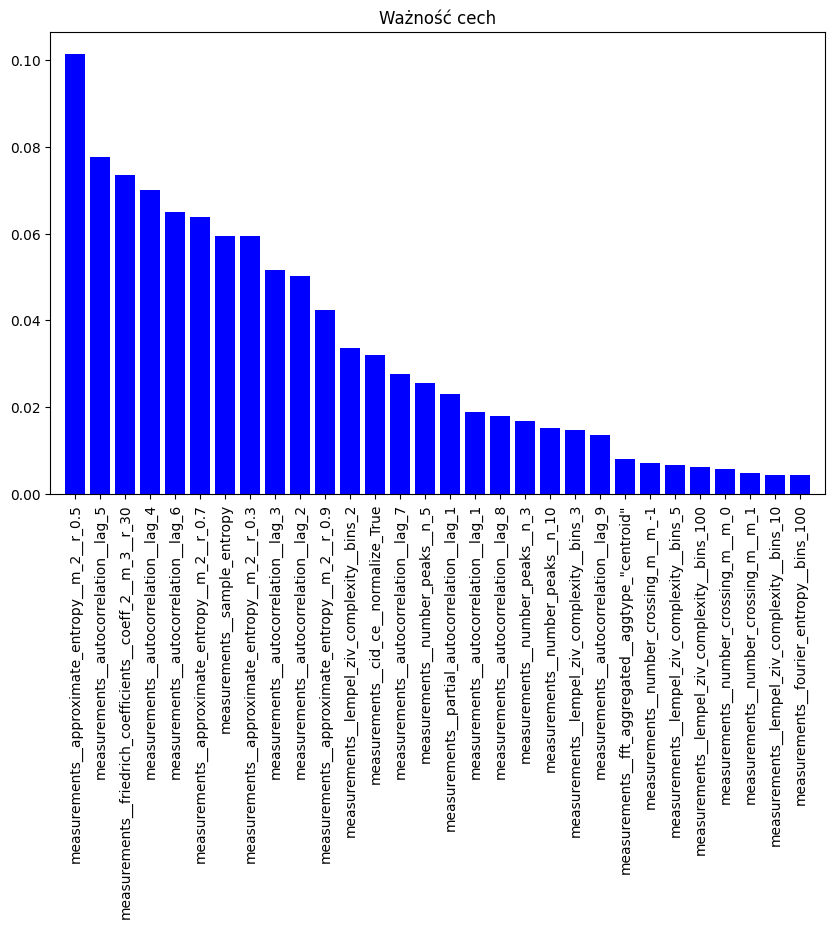

In [ ]:
X = df_feat
y = y

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wczytanie lasu losowego i przeprowadzenie klasyfikacji na danych ze standaryzacją
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
importances = rf_classifier.feature_importances_

# Wizualizacja ważności cech
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Ważność cech")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X_train_scaled.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

# utworzenie df z istotnymi cechami
imp = pd.DataFrame({"importance": importances, "names": df_feat.columns})

Analizując wykres możemy zdecydować ile cech należy uwzględnić - **na początku zdecydujmy się na 15 cech.**

In [ ]:
features_1 = []
numb_of_feat = 15

# Wybór 15 najlepszych cech
most_important_features = imp.nlargest(numb_of_feat, 'importance')
features_1.append(most_important_features["names"])

# Utworzenie dataframe'u
df_features_1 = df_feat[most_important_features["names"]]
df_features_1.shape

(500, 15)

## [6.2] Analiza korelacji między wybranymi cechami - ograniczenie do 7 cech

Na początek zobaczmy pairplot dla 15 cech wybranych do tej pory.

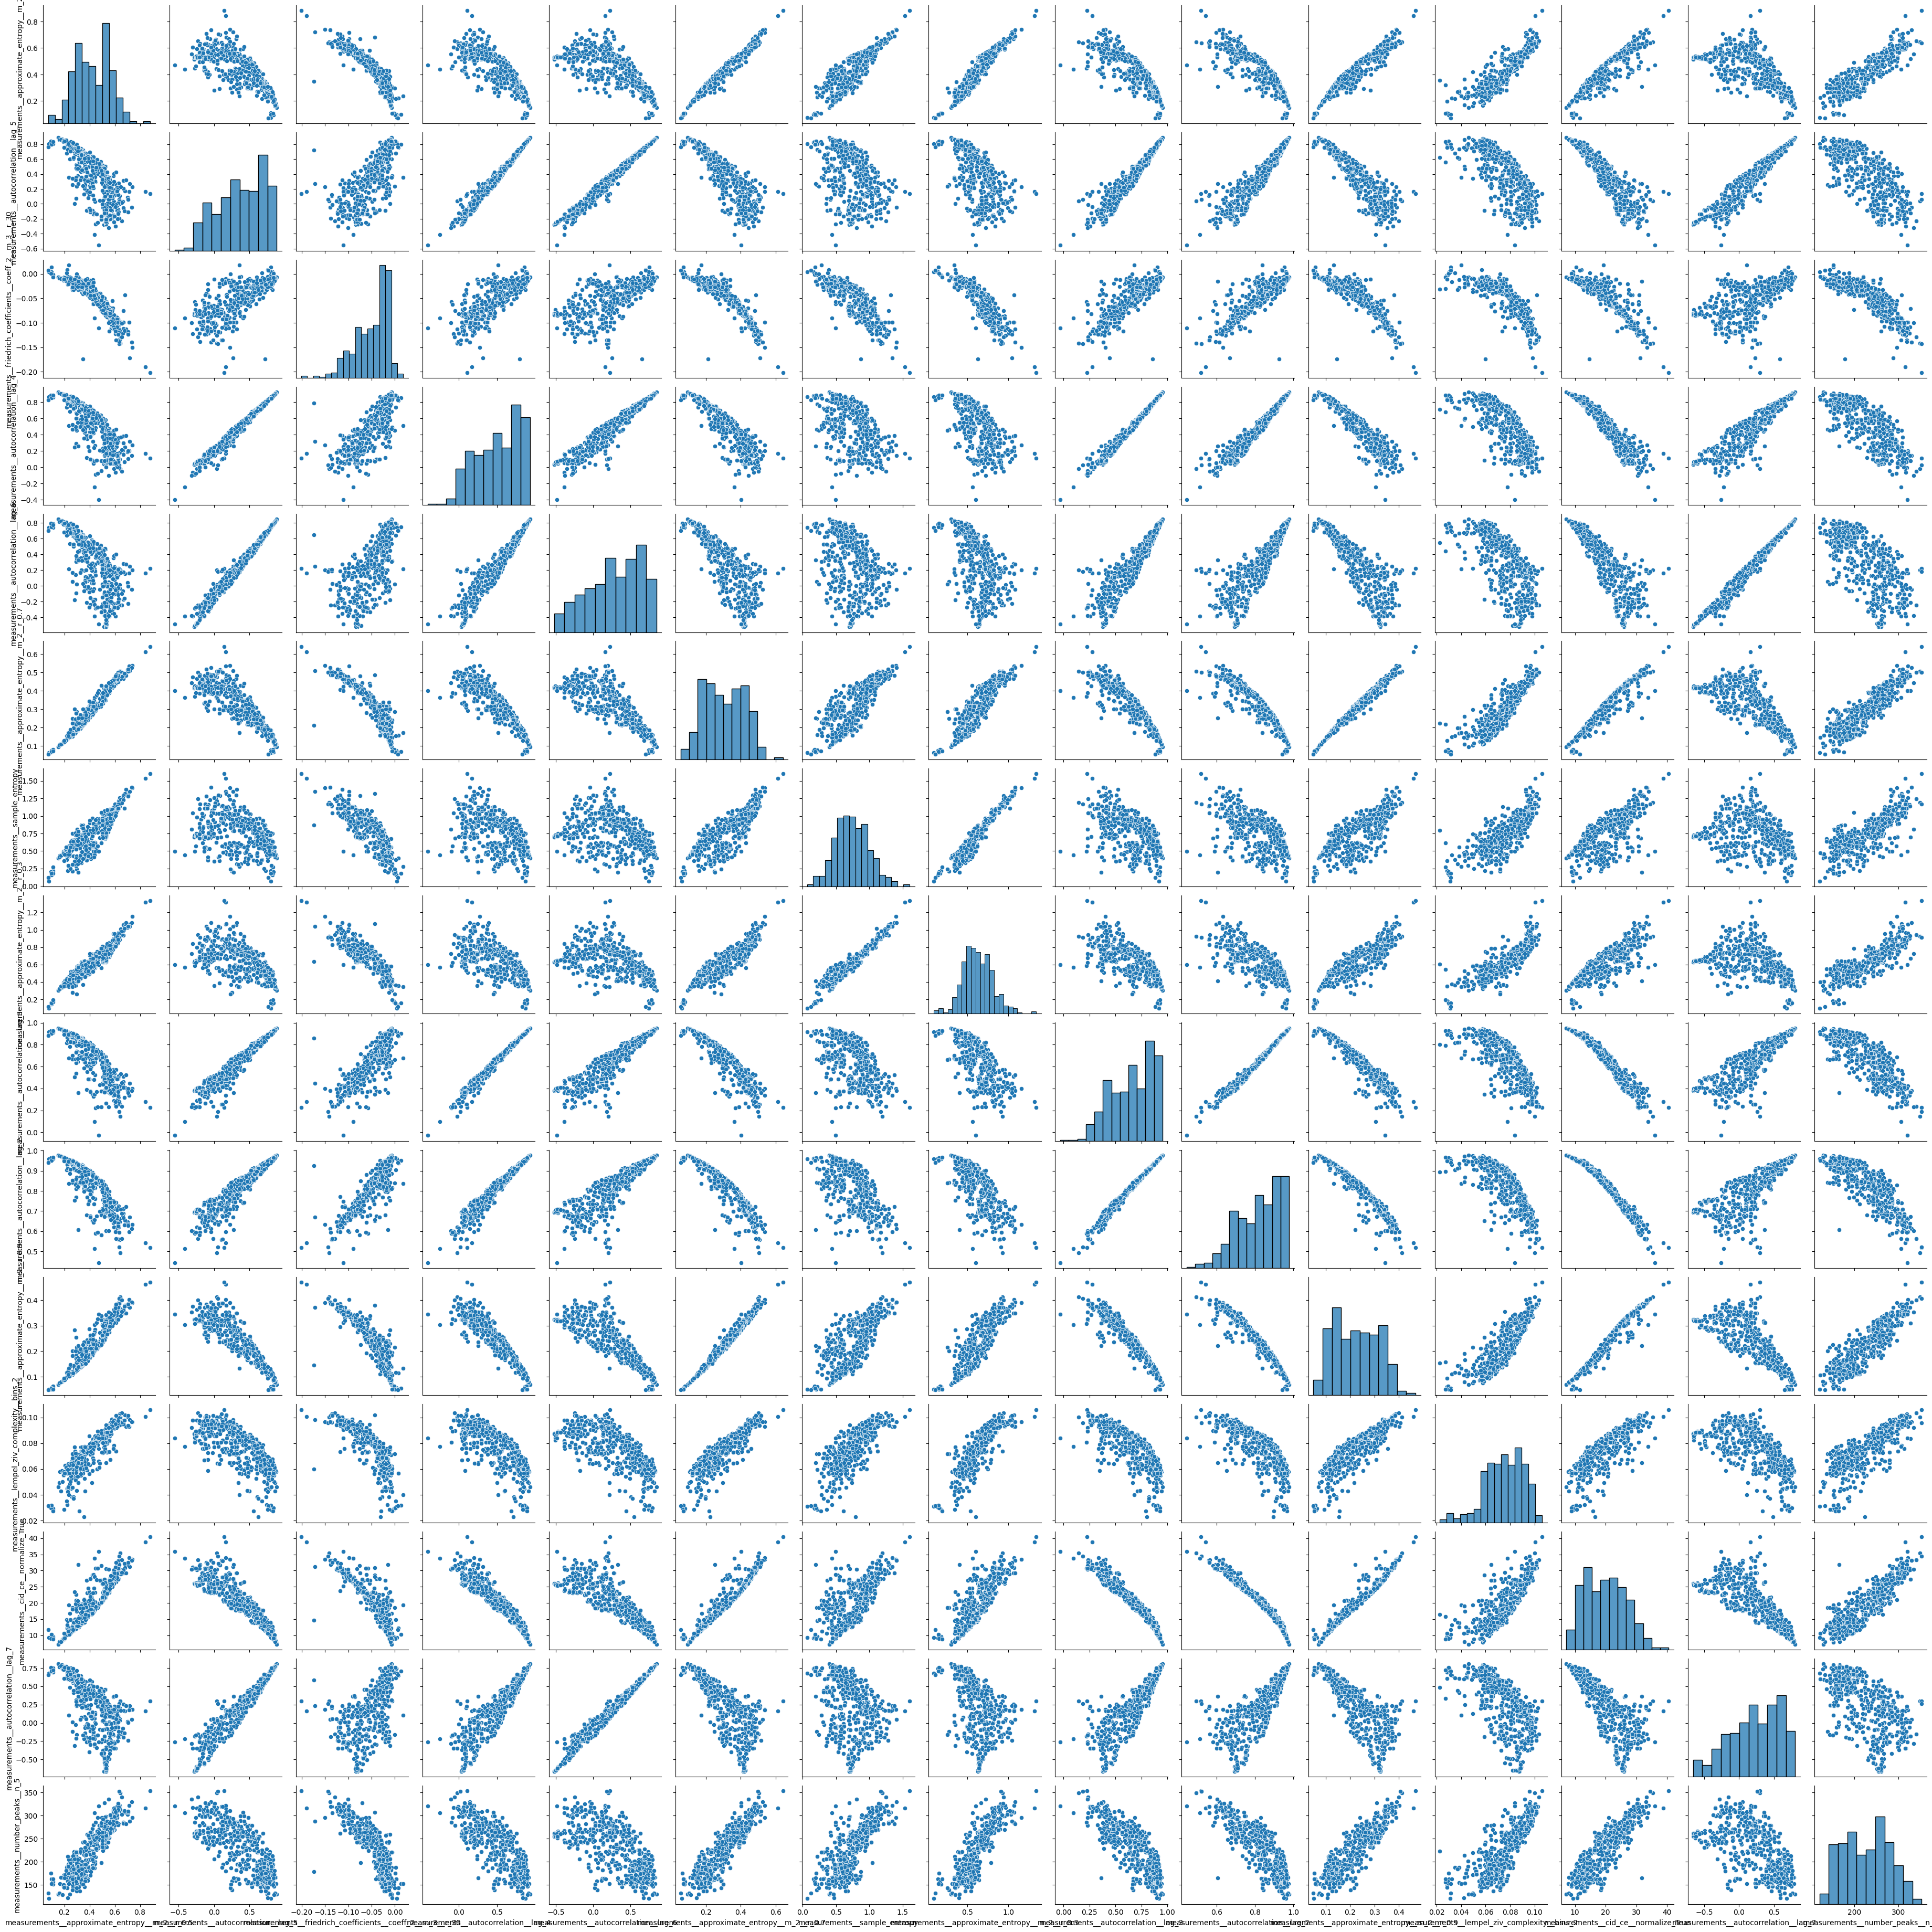

In [ ]:
# Pairplot dla wybranych 15 cech
data_corr = df_features_1.copy()
sns.pairplot(data_corr)

Z tego względu, że obecne są wartości odstające, a związek międzyt zmiennymi jest w większości monotoniczny, obliczamy **współczynnik korelacji Spearmana**.

>**H0:** Nie ma zależności pomiędzy zmiennymi.
>
>**H1:** Jest zależność pomiędzy zmiennymi.

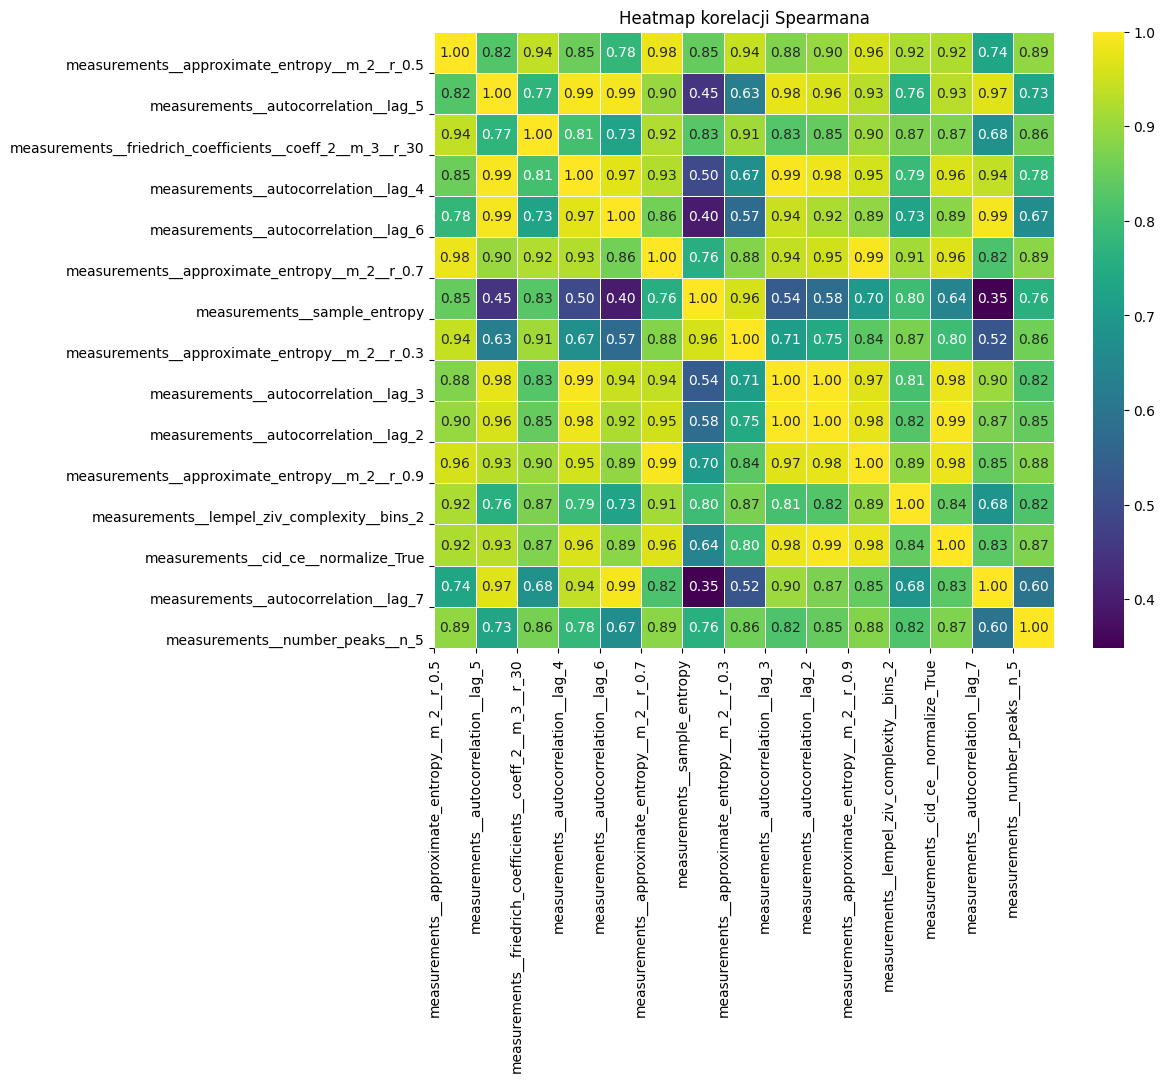

In [ ]:
datacor = data_corr.corr(method = 'spearman')

# Narysuje go sobie, bo lepiej trochę widać wtedy na pierwszy rzut oka.
# Co więcej, zrobię to dla wartości bezwzględnych, bo tu w sumie chodzi
# o to tylko jak mała jest korelacja między zmiennymi
plt.figure(figsize=(10, 8))
sns.heatmap(datacor.abs(), cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap korelacji Spearmana')

column_names = datacor.columns.tolist()
plt.xticks(list(range(0, 15)), column_names, rotation=90)
plt.yticks(list(range(1, 16)), column_names, rotation=0, va='bottom')
plt.show()

In [ ]:
# Sprawdźmy czy te współczynniki mają statystyczne znaczenie
res15 = pg.pairwise_corr(datacor, method='spearman')
res15.sort_values(by='p-unc', ascending=False).head(10)

X  \
75                   measurements__sample_entropy   
51           measurements__autocorrelation__lag_6   
82  measurements__approximate_entropy__m_2__r_0.3   
52           measurements__autocorrelation__lag_6   
18           measurements__autocorrelation__lag_5   
19           measurements__autocorrelation__lag_5   
41           measurements__autocorrelation__lag_4   
70                   measurements__sample_entropy   
71                   measurements__sample_entropy   
42           measurements__autocorrelation__lag_4   

                                                Y    method alternative   n  \
75           measurements__autocorrelation__lag_7  spearman   two-sided  15   
51                   measurements__sample_entropy  spearman   two-sided  15   
82           measurements__autocorrelation__lag_7  spearman   two-sided  15   
52  measurements__approximate_entropy__m_2__r_0.3  spearman   two-sided  15   
18                   measurements__sample_entropy  spearman   two-sided  15   
19  measurements__approximate_entropy__m_2__r_0.3  spearman   two-sided  15   
41                   measurements__sample_entropy  spearman   two-sided  15   
70           measurements__autocorrelation__lag_3  spearman   two-sided  15   
71           measurements__autocorrelation__lag_2  spearman   two-sided  15   
42  measurements__approximate_entropy__m_2__r_0.3  spearman   two-sided  15   

           r           CI95%     p-unc     power  
75 -0.517857  [-0.81, -0.01]  0.048004  0.532858  
51 -0.521429  [-0.82, -0.01]  0.046219  0.539765  
82 -0.539286  [-0.82, -0.04]  0.038022  0.574603  
52 -0.542857  [-0.83, -0.04]  0.036522  0.581619  
18 -0.560714  [-0.83, -0.07]  0.029676  0.616835  
19 -0.582143   [-0.84, -0.1]  0.022794  0.659119  
41 -0.614286  [-0.86, -0.15]  0.014834  0.721566  
70 -0.632143  [-0.86, -0.18]  0.011458  0.755174  
71 -0.635714  [-0.87, -0.18]  0.010861  0.761764  
42 -0.635714  [-0.87, -0.18]  0.010861  0.761764

**Komentarz:** Na poziomie istotności alfa=0.02, wartość p>alfa, co oznacza że dla par numer 75, 51, 82, 52, 18 oraz 19, nie ma podstaw do odrzucenia H0, że nie ma zależności między zmiennymi (bo p>alfa).

**Co dalej?** Wybieram 7 cech, na podstawie tego, które mają najmniejszą korelację, lub najmniej statystycznie istotną korelację. Nie da się tego zrobić idealnie, ale ograniczamy negatywny wpływ wyboru skorelowanych zmiennych biorąc pod uwagę właśnie korelację między zmiennymi.

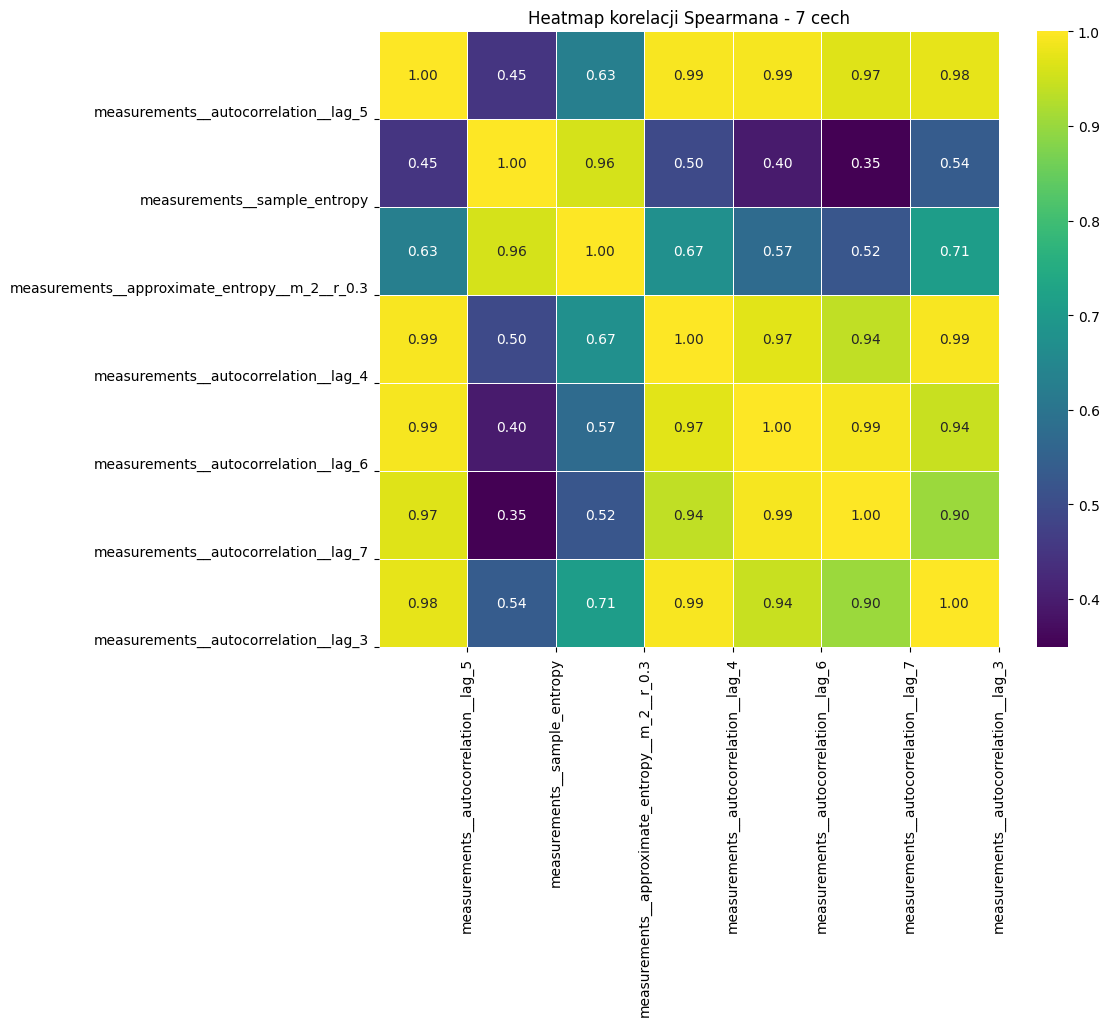

In [ ]:
# Sprawdźmy
df_features_7 = df_features_1[['measurements__autocorrelation__lag_5', 'measurements__sample_entropy',
                                 'measurements__approximate_entropy__m_2__r_0.3', 'measurements__autocorrelation__lag_4',
                                 'measurements__autocorrelation__lag_6', 'measurements__autocorrelation__lag_7',
                                 'measurements__autocorrelation__lag_3']]

datacor_7 = df_features_7.corr(method = 'spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(datacor_7.abs(), cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap korelacji Spearmana - 7 cech')

column_names = datacor_7.columns.tolist()
plt.xticks(list(range(1, 8)), column_names, rotation=90)
plt.yticks(list(range(1, 8)), column_names, rotation=0, va='bottom')
plt.show()

In [ ]:
# Tworzę tabelę z korelacjami i sortuje względem wartości absolutnej
# Sprawdźmy czy te współczynniki mają statystyczne znaczenie
res8 = pg.pairwise_corr(datacor_7, method='spearman')
res8.sort_values(by='p-unc', ascending=False)

X  \
9                    measurements__sample_entropy   
20           measurements__autocorrelation__lag_7   
13  measurements__approximate_entropy__m_2__r_0.3   
8                    measurements__sample_entropy   
12  measurements__approximate_entropy__m_2__r_0.3   
19           measurements__autocorrelation__lag_6   
16           measurements__autocorrelation__lag_4   
15           measurements__autocorrelation__lag_4   
4            measurements__autocorrelation__lag_5   
3            measurements__autocorrelation__lag_5   
0            measurements__autocorrelation__lag_5   
1            measurements__autocorrelation__lag_5   
5            measurements__autocorrelation__lag_5   
2            measurements__autocorrelation__lag_5   
7                    measurements__sample_entropy   
11  measurements__approximate_entropy__m_2__r_0.3   
6                    measurements__sample_entropy   
17           measurements__autocorrelation__lag_4   
18           measurements__autocorrelation__lag_6   
10                   measurements__sample_entropy   
14  measurements__approximate_entropy__m_2__r_0.3   

                                                Y    method alternative  n  \
9            measurements__autocorrelation__lag_7  spearman   two-sided  7   
20           measurements__autocorrelation__lag_3  spearman   two-sided  7   
13           measurements__autocorrelation__lag_7  spearman   two-sided  7   
8            measurements__autocorrelation__lag_6  spearman   two-sided  7   
12           measurements__autocorrelation__lag_6  spearman   two-sided  7   
19           measurements__autocorrelation__lag_3  spearman   two-sided  7   
16           measurements__autocorrelation__lag_7  spearman   two-sided  7   
15           measurements__autocorrelation__lag_6  spearman   two-sided  7   
4            measurements__autocorrelation__lag_7  spearman   two-sided  7   
3            measurements__autocorrelation__lag_6  spearman   two-sided  7   
0                    measurements__sample_entropy  spearman   two-sided  7   
1   measurements__approximate_entropy__m_2__r_0.3  spearman   two-sided  7   
5            measurements__autocorrelation__lag_3  spearman   two-sided  7   
2            measurements__autocorrelation__lag_4  spearman   two-sided  7   
7            measurements__autocorrelation__lag_4  spearman   two-sided  7   
11           measurements__autocorrelation__lag_4  spearman   two-sided  7   
6   measurements__approximate_entropy__m_2__r_0.3  spearman   two-sided  7   
17           measurements__autocorrelation__lag_3  spearman   two-sided  7   
18           measurements__autocorrelation__lag_7  spearman   two-sided  7   
10           measurements__autocorrelation__lag_3  spearman   two-sided  7   
14           measurements__autocorrelation__lag_3  spearman   two-sided  7   

           r           CI95%     p-unc     power  
9  -0.250000   [-0.84, 0.62]  0.588724  0.084547  
20  0.285714    [-0.6, 0.85]  0.534509  0.096195  
13 -0.285714    [-0.85, 0.6]  0.534509  0.096195  
8  -0.285714    [-0.85, 0.6]  0.534509  0.096195  
12 -0.321429   [-0.87, 0.57]  0.482072  0.109889  
19  0.321429   [-0.57, 0.87]  0.482072  0.109889  
16  0.321429   [-0.57, 0.87]  0.482072  0.109889  
15  0.357143   [-0.54, 0.87]  0.431611  0.125825  
4   0.535714   [-0.36, 0.92]  0.215217  0.248486  
3   0.607143   [-0.27, 0.93]  0.148231  0.324216  
0  -0.714286   [-0.95, 0.08]  0.071344  0.477804  
1  -0.750000   [-0.96, 0.01]  0.052181  0.541563  
5   0.750000   [-0.01, 0.96]  0.052181  0.541563  
2   0.821429    [0.18, 0.97]  0.023449  0.688888  
7  -0.928571  [-0.99, -0.58]  0.002519  0.931095  
11 -0.964286  [-0.99, -0.77]  0.000454  0.986148  
6   0.964286    [0.77, 0.99]  0.000454  0.986148  
17  0.964286    [0.77, 0.99]  0.000454  0.986148  
18  0.964286    [0.77, 0.99]  0.000454  0.986148  
10 -0.964286  [-0.99, -0.77]  0.000454  0.986148  
14 -1.000000    [-1.0, -1.0]  0.000000  1.000000

**Komentarz:** 7 spośród 20 par (7, 11, 6, 17, 18, 10, 14) zmiennych są statystycznie istotnie skorelowane (p<alfa -> odrzucamy H0 i przyjmujemy H1, że jest zależność między zmiennymi).


# [7] Wstępna klasyfikacja z zastosowaniem sieci neuronowej
Na podstawie 7 wybranych cech.

## [7.1] Przygotowanie środowiska i danych

In [ ]:
# Możliwość podłączenia pod GPU -> środowisko wykonawcze -> Zmień typ środowiska wykonawczego -> T4 GPU (nieobowiązkowe)
device = "cuda" if torch.cuda.is_available() else "cpu"

# zdefiniowanie nasionka raz jeszce
seed = 24

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
X = df_features_7
y = df['class']

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reset indeksów
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

### [7.1.1] Utworzenie klasy CancerDataset

Utworzenie klasy jest niezbędne, ponieważ PyTorch działa na tensorach, a klasa umożliwia zamianę wejściowego typu zmiennych na tensory.

In [ ]:
class CancerDataset(Dataset):

  def __init__(self,
               samples: pd.DataFrame,           # DataFrame
               labels: List[int],               # etykiety
               device: str):                    # GPU/CPU
    self.samples = samples
    self.labels = labels
    self.device = device

    """
    self - podczas pracy z klasami w Pythonie termin 'self' odnosi się do instancji aktualnie używanej klasy.
    Zwyczajowo używa się 'self' jako pierwszego parametru w metodach instancji klasy.
    Za każdym razem, gdy wywołujesz metodę obiektu utworzonego z klasy, obiekt ten jest automatycznie przekazywany
    jako pierwszy argument przy użyciu parametru 'self'.
    Umożliwia to modyfikowanie właściwości obiektu i wykonywanie zadań unikalnych dla tej konkretnej instancji.
    """

  def __getitem__(self, idx: int) -> Tuple[pd.DataFrame, int]:
    """
       Specjalna metoda klasy która pozwala traktować obiekt tej klasy jak listę
       i indeksować jej elementy z wykorzystaniem parametru 'idx'.
       W tym przypadku indeksujemy konkretne elementy zbioru treningowego lub
       testowego zdefiniowanego w zmiennej 'samples' oraz powiązane z nim
       etykiety klas zdefiniowane w 'labels'.
    """
    sample = torch.from_numpy(self.samples.iloc[idx].values)
    label = torch.tensor(self.labels.iloc[idx])
    return sample.to(device).float(), label.to(device).long()

  def __len__(self) -> int:
    """
       Metoda klasy pozwalająca na zdefiniowanie możliwości sprawdzenia ilości
       elementów jaką ta klasa posiada. W tym przypadku długość obiektu klasy
       jest powiązana z ilością elementów zdefinionwaych w zmiennej `samples`
    """
    return len(self.samples)

## [7.2] Dataloader

Ucząc model, zazwyczaj chcemy przekazywać próbki w minipaczkach oraz przetasowywać dane w każdej epoce (shuffle), aby ograniczyć nadmierne dopasowanie modelu.

Hiperparametr: `batch_size` ("wielkość minipaczki", "wielkosć wsadu", "mini partie") - ile próbek ze zbioru treningowego/testowego wykorzystywanych jest w jednej iteracji - oznacza to, że ten hiperparametr określa liczbę iteracji w jednej epoce.

In [ ]:
train_dataset = CancerDataset(X_train, y_train, device)
test_dataset = CancerDataset(X_test, y_test, device)

# długość zbioru treningowego
print('Długość zbioru treningowego:', len(train_dataset))

# 0 wiersz zbioru treningowego
print('0 wiersz zbioru treningowego:', train_dataset[0])

Długość zbioru treningowego: 350
0 wiersz zbioru treningowego: (tensor([0.0855, 1.2914, 1.0278, 0.1882, 0.0395, 0.0184, 0.3792]), tensor(0))


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 10, shuffle = True)        # shuffle =  True -> przetasowanie zbioru
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle = True)

## [7.3] Przygotowanie sieci

**Utworzenie klasy sieci:**

1. zdefiniowanie warstw sieci (pojemności modelu), danych jest niewiele dlatego liczba warstw oraz liczba neuronów w każdej warstwie nie może być zbyt duża, aby nie doszło do przetrenowania modelu - nadmiernego dopasowania,

2. funkcja aktywacji - skaluje wyjście z warstwy, definiujemy ją po zdefiniowaniu warstwy, nie musi być ona wykorzystywana przy każdej warstwie (możemy jej w ogóle nie wykorzystywać),

3. wykorzystanie funkcjonalności klasy bazowej.

Wykorzystamy funkcję aktywacji ReLU (rectified linear unit function)

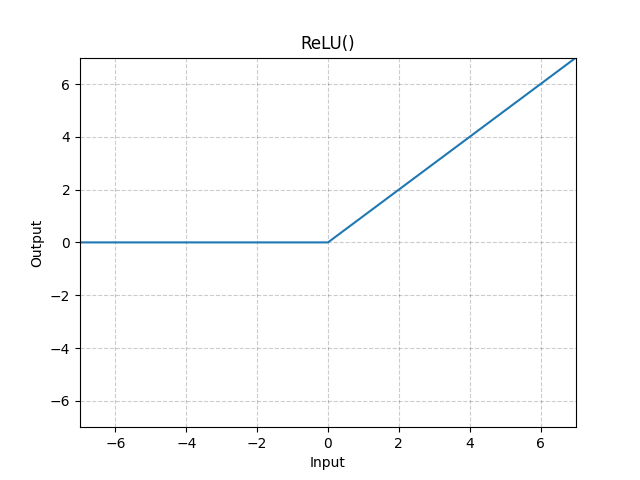

In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()                      # wywołanie funkcji inicjalizującej z klasy bazowej (nn.Module)

        self.input_length = 7                   # liczba cech
        self.output_length = 3                  # liczba: klas normalny (0), międzynapadowy (2), napad (1)

        self.model = nn.Sequential(
            nn.Linear(self.input_length, 25),   # warstwa wejściowa -> 7 cech na wejściu, 25 neuronów na wyjściu
            nn.ReLU(),
            nn.Linear(25, 50),                  # 2 warstwa -> 25 neuronów na wejściu i 50 neuronów na wyjściu
            nn.ReLU(),
            nn.Linear(50, 100),                 # 3 warstwa -> 50 neuronów na wejściu i 100 neuronów na wyjściu
            nn.ReLU(),
            nn.Linear(100, 50),                 # 4 warstwa -> 100 neuronów na wejściu i 50 neuronów na wyjściu
            nn.ReLU(),
            nn.Linear(50, self.output_length),  # 5 warstwa -> 50 neuronów na wejściu i 3 neurony wyjściowe (bo mamy 3 klasy)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:     # wykorzystanie funkcjonalności z klasy bazowej
        return self.model(input)

In [ ]:
neural_network = NeuralNetwork()

if device == "cuda":                             # erwntualne przekazanie na GPU
  neural_network.cuda()

# Kod treningowy
learning_rate = 0.008                          # współczynnik uczenia skalujący gradient optymalizatora
epochs = 200                                   # liczba epok treningowych sieci neuronowej

# Funkcja kosztu zdefiniowanej sieci neuronowej - specyficzna dla danego problemu (klasyfikacja wieloklasowa)
criterion = nn.CrossEntropyLoss()

# Optymalizator - optymalizacja szybkości uczenia się, obliczanie wag sieci w celu minimalizacji funkcji kosztu (minimalizacja błędu między predykcją a etykietą klasy)
optimizer = optim.Adam(neural_network.parameters(), lr=learning_rate)

# Orkiestrator (orchestrator -> scheduler) wspołczynnika uczenia, który będzie miał za zadanie zmianę
# wartości współczynnika uczenia w zależności od tego, czy odpowiednia metryka
# zdefiniowana w procesie uczenia ulega konkretnej zmianie

learning_rate_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min=0.001)

## [7.4] Trening sieci

In [ ]:
# Utworzenie list z loss i accuracy
training_loss_values = []
training_accuracy_values = []

validation_loss_values = []
validation_accuracy_values = []

# zdefiniowanie metryk treningowych i walidacyjnych - w naszym wypadku dokładności
training_accuracy= torchmetrics.classification.MulticlassAccuracy(num_classes=3)
validation_accuracy= torchmetrics.classification.MulticlassAccuracy(num_classes=3)

# zdefiniowanie treningu sieci
for epoch in range(epochs):                                                     # iteracja po liczbie epok
  total_loss = 0.0                                                              # zmienna do akumulacji błędu uczenia w trakcie trwania epoki (zawsze 0.0)
  total_batches = 0                                                             # zmienna początkowa sumowania minipaczek (zawsze 0)

  for idx, (train_samples, labels) in enumerate(train_dataloader):
    predictions = neural_network(train_samples)                                 # dodanie danych treningowych do sieci

    loss = criterion(predictions, labels)                                       # obliczenie funkcji kosztu

    loss.backward()                                                             # obliczenie gradientu względem każdej wagi sieci
    optimizer.step()                                                            # zaaplikowanie gradientu do wag sieci z wykorzystaniem algorytmu wstecznej propagacji błędu (wpływ wag na predykcję)
    learning_rate_scheduler.step()                                              # przeskalowanie współczynnika uczenia

# dodanie predykcji i etykiet do zdefiniowanych metryk w celu późniejszego ich obliczenia
    training_accuracy.update(predictions, labels)

    optimizer.zero_grad()                                                       # zerowanie gradientu

    total_loss += loss.item()
    total_batches += 1

  average_loss = total_loss / total_batches                                     # średni błąd uczenia

# obliczenie wcześniej zdefiniowanych metryk
  train_accuracy= training_accuracy.compute()

  print(f'Epoch [{epoch + 1}] average loss: {average_loss:.3f} Accuracy: {training_accuracy.compute():.3f}')

  training_loss_values.append(average_loss)
  training_accuracy_values.append(float(train_accuracy))

# wyłączenie obliczania gradientu przez sieć w trakcie walidacji (gradient wyznaczamy tylko podczas treningu)
  with torch.no_grad():
    val_loss = 0
    for idx, (test_samples, labels) in enumerate(test_dataloader):

        predictions = neural_network(test_samples)
        val_loss += criterion(predictions, labels).item()

        validation_accuracy.update(predictions, labels)

        total_batches += 1

    val_loss /= total_batches                                                   # błąd walidacji - jaka część próbek została błędnie sklasyfikowana
    val_accuracy= validation_accuracy.compute()

    print(f'Validation Loss: {val_loss:.3f} Accuracy: {val_accuracy:.3f}')

    validation_loss_values.append(val_loss)
    validation_accuracy_values.append(float(val_accuracy))


Epoch [1] average loss: 0.830 Accuracy: 0.538
Validation Loss: 0.192 Accuracy: 0.600
Epoch [2] average loss: 0.603 Accuracy: 0.576
Validation Loss: 0.198 Accuracy: 0.606
Epoch [3] average loss: 0.575 Accuracy: 0.605
Validation Loss: 0.170 Accuracy: 0.639
Epoch [4] average loss: 0.519 Accuracy: 0.650
Validation Loss: 0.152 Accuracy: 0.678
Epoch [5] average loss: 0.455 Accuracy: 0.685
Validation Loss: 0.115 Accuracy: 0.714
Epoch [6] average loss: 0.336 Accuracy: 0.715
Validation Loss: 0.104 Accuracy: 0.741
Epoch [7] average loss: 0.322 Accuracy: 0.738
Validation Loss: 0.165 Accuracy: 0.751
Epoch [8] average loss: 0.335 Accuracy: 0.754
Validation Loss: 0.151 Accuracy: 0.758
Epoch [9] average loss: 0.291 Accuracy: 0.770
Validation Loss: 0.085 Accuracy: 0.777
Epoch [10] average loss: 0.294 Accuracy: 0.782
Validation Loss: 0.093 Accuracy: 0.788
Epoch [11] average loss: 0.229 Accuracy: 0.794
Validation Loss: 0.158 Accuracy: 0.792
Epoch [12] average loss: 0.291 Accuracy: 0.802
Validation Loss:

## [7.5] Wyniki uczenia
Zobaczmy jak sobie poradziała sieć.

### [7.5.1] Krzywe uczenia

#### [7.5.1.1] Training and validation loss

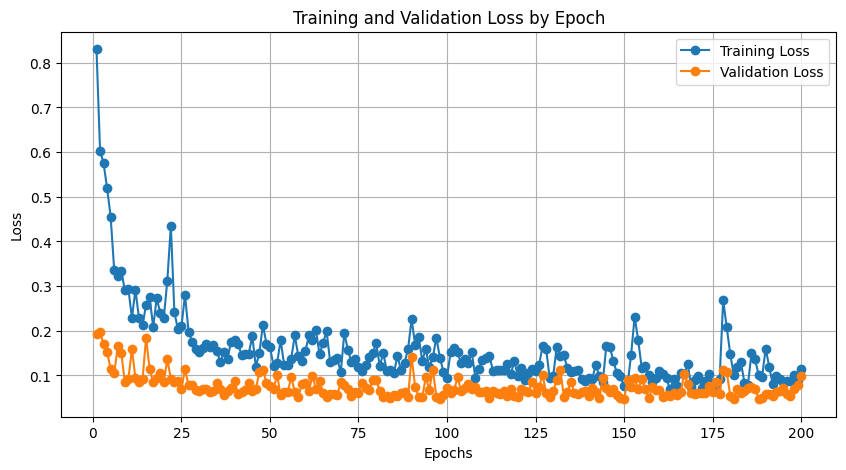

In [ ]:
# wektor epok
_epochs = list(range(1, len(training_loss_values) + 1))

# narysowanie krzywych uczenia
plt.figure(figsize=(10, 5))

# krzywa treningowa
plt.plot(_epochs, training_loss_values, label='Training Loss', marker='o')

# krzywa walidacyjna
plt.plot(_epochs, validation_loss_values, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

**KOMENTARZ:**

**Linią niebieską** zaznaczona została krzywa uczenia **danych treningowych** podczas trwania epok uczenia (jeden punkt na wykresie odpowiada jednej wartości funkcji kosztu danych treningowych w tej epoce), która asymptotycznie zmierza do zera (minimalizacja funkcji kosztu). **Linią pomarańczową** natomiast mamy zaznaczone **dane walidacyjne**.

Strata treningowa wykazuje stały trend malejący, rozpoczynając od relatywnie wysokiej wartości i stopniowo malejąc w trakcie kolejnych epok. To wskazuje, że **model skutecznie uczy się na podstawie danych treningowych**. Jednocześnie strata walidacyjna również wykazuje trend malejący, co sugeruje, że model **dobrze generalizuje do nowych danych**. Choć strata walidacyjna konsekwentnie pozostaje nieco wyższa niż strata treningowa, co jest zjawiskiem oczekiwanym, zbieżność obu krzywych w późniejszych epokach wskazuje na **ustabilizowanie się modelu.**

Przy dokładniejszej analizie krzywych strat można zauważyć, że sieć neuronowa mogła osiągnąć optymalny punkt zbieżności w okolicach 100-150 epok, gdzie zarówno strata treningowa, jak i walidacyjna się ustabilizowały. Oznacza to, że dalsze szkolenie może przynieść malejące korzyści, a model prawdopodobnie już opanował istotne wzorce w danych.

#### [7.5.1.2] Training and validation accuracy
Podczas trwania uczenia i walidacji accuracy powinno rosnąć zbliżając się do 1.

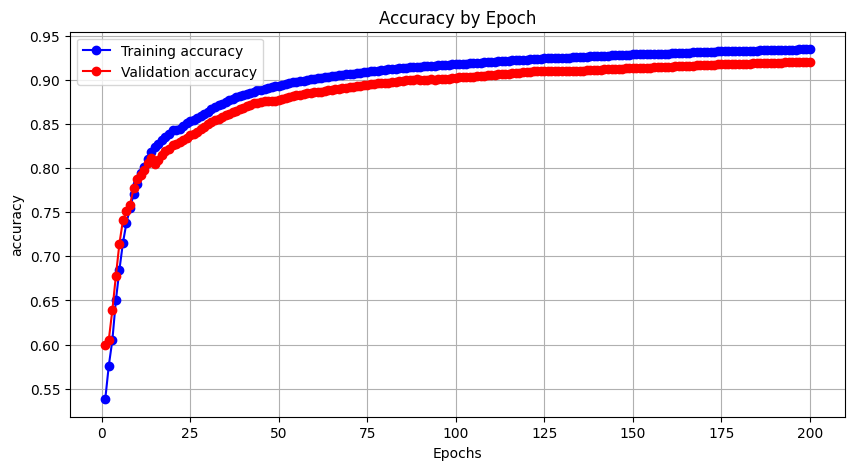

In [ ]:
# Generate a range of epochs based on the length of the loss lists
_epochs = list(range(1, len(training_accuracy_values) + 1))

# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(_epochs, training_accuracy_values, label='Training accuracy', marker='o', color='blue')

# Plotting the validation accuracy
plt.plot(_epochs, validation_accuracy_values, label='Validation accuracy', marker='o', color='red')

plt.title('Accuracy by Epoch')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()

**KOMENTARZ:**

Podane wartości dokładności reprezentują wyniki sieci neuronowej w trakcie procesu uczenia. Zarówno dokładność w trakcie treningu, jak i na zbiorze walidacyjnym, wykazuje **spójny trend wzrostowy**, co wskazuje, że sieć uczy się i poprawia swoją zdolność do dokładnych prognoz. Analiza tych krzywych wskazuje na podobne wnioski jak po analizie krzywych straty - model zdaje się dobrze generalizować do niewidzianych danych, o czym świadczy podobny wzrost dokładności na zbiorze walidacyjnym jak w przypadku zbioru treningowego.

Przyjrzenie się konkretym wartościom pokazuje, że dokładność na zbiorze walidacyjnym zaczyna się od około 60% i stopniowo rośnie, osiągając około 92%. Natomiast dokładność treningowa zaczyna od 53% i osiąga około 93%. **Wzrost dokładności walidacyjnej sugeruje, że model nie przeucza się, a jego zdolności na zbiorze walidacyjnym poprawiają się wraz z dłuższym treningiem.**

Warto zauważyć, że bezwzględne wartości dokładności zależą od charakteru problemu i zbioru danych. W zadaniach klasyfikacji zazwyczaj dążymy do uzyskania jak najwyższych wartości dokładności, jednak interpretacja końcowa zależy od konkretnego kontekstu i wymagań zastosowania.

### [7.5.2] Macierz pomyłek i metryki

W kontekście danych medycznych, czyli takich jak mamy w tym zadaniu, macierz pomyłek staje się kluczowa. Wskaźnik prawdziwie pozytywnych i wskaźnik prawdziwie negatywnych są istotnymi metrykami, ponieważ oceniają zdolność modelu do poprawnego identyfikowania ataków padaczkowych i stanów normalnych.

Fałszywie pozytywne (czyli stany normalne zaklasyfikowane jako międzynapadowe lub napadowe) mogą prowadzić do niepotrzebnych interwencji. Ale największym niebezpieczeństwem mogą być przypadki fałszywie negatywne (czyli międzynapadowe lub napadowe zaklasyfikowane jako normalne), bo mogą skutkować pominięciem poważnych stanów pacjenta, co ma istotne znaczenie w kontekście medycznym.

Text(0.5, 1.0, 'Confusion Matrix')

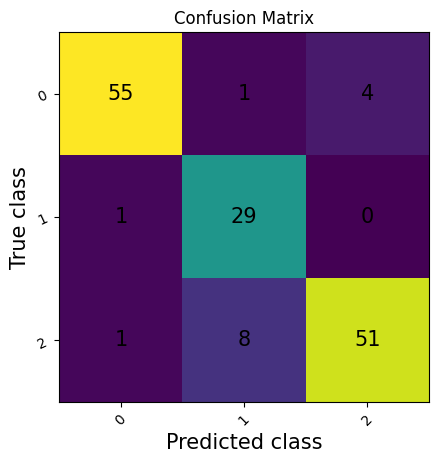

In [ ]:
# Wyznaczanie macierzy pomyłek
test_confusion_matrix = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=3)

preds = []
labels = []

with torch.no_grad():
  for idx, (test_samples, test_labels) in enumerate(test_dataset):
    predictions = neural_network(test_samples)
    predictions = predictions.argmax(dim=0).unsqueeze(0)
    test_labels = test_labels.unsqueeze(0)
    test_confusion_matrix.update(predictions, test_labels)

    preds.extend(predictions.tolist())
    labels.extend(test_labels.tolist())

fig_1, ax_1 = test_confusion_matrix.plot()

ax_1.set_title(f"Confusion Matrix")

In [ ]:
# metryki
print(classification_report(preds, labels))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        57
           1       0.97      0.76      0.85        38
           2       0.85      0.93      0.89        55

    accuracy                           0.90       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.90      0.90      0.90       150



**KOMENTARZ:**

Mimo dobrych wyników dokładności, macierz pomyłek wskazuje na to, że z modelem są pewne problemy. Przy analizie należy wziąć pod uwagę, że to są dane medyczne. Chcielibyśmy zatem, żeby żaden stan międzynapadowy lub napadowy NIE ZOSTAŁ sklasyfikowany jako normalny. Niestety w tym przypadku 4 sygnały międzynapadowe i 1 sygnał napadowy został sklasyfikowany jako normalny. Jest zatem miejsce do dużych poprawek modelu.

# [8] Zastosowanie shap.KernelExplainer
(SHapley Additive exPlanations)

W przypadku sieci istnieje wiele metod selekcji cech oraz interpretacji modelu - większość z nich pokrywa się z tymi, które wykorzystywane są do interpretacji modeli uczenia nadzorowanego. Otrzymane wyniki dla sieci są jednak mniej dokładne. Jest to związane z trudnością interpretacji samej sieci oraz całego procesu uczenia.

W tym projekcie wykorzystam **SHAP - KernelExplainer**. Jest to metoda wykorzystująca ważoną regresję liniową w celu obliczenia ważności każdej z cech.

In [ ]:
# Przygotowanie analizy
torch.manual_seed(seed)
np.random.seed(seed)

input = torch.from_numpy(X_test.values)
feature_perm = FeaturePermutation(neural_network)
attr = feature_perm.attribute(input.float())

data = input.float().numpy()

f = lambda x: neural_network(torch.from_numpy(x)).detach().numpy()    # przejście między tensorami a macierzami

explainer = KernelExplainer(f, data)

shap_values = explainer.shap_values(data)

shap.initjs()

feature_names = X_test.columns

  0%|          | 0/150 [00:00<?, ?it/s]

## [8.1] Analiza zbiorcza
Czyli które cechy mają największy wpływ na wybranie poszczególnych klas.

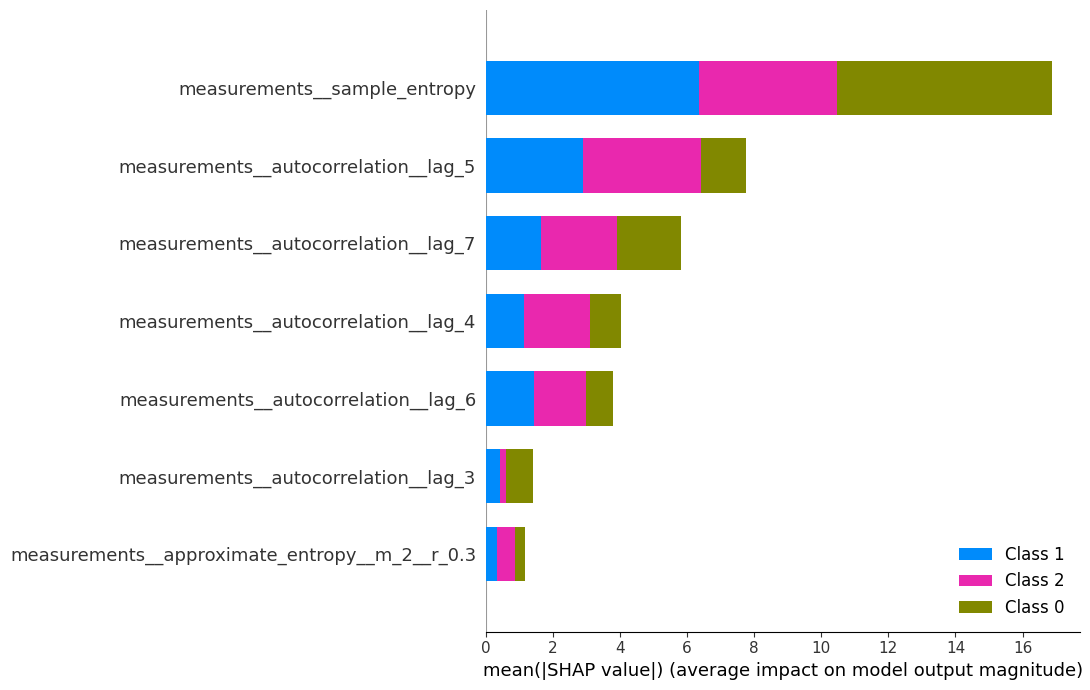

In [ ]:
# Analiza modelu
shap.summary_plot(shap_values, data, feature_names, plot_size=(11, 7))

**Interpretacja wyniku:** Analiza wskazuje, które cechy jak mocno wpływają na wybór każdej z klas. Wyniki pokazują, że cecha `measurements__sample_entropy` ma największy wpływ na wybór każdej z klas (porównywalnie dla klasy 1 i 2, delikatnie mniej dla klasy 2).

Kolejne cechy - `measurements__autocorrelation__lag_5`, `measurements__autocorrelation__lag_7` oraz `measurements__autocorrelation__lag_4` i `measurements__autocorrelation__lag_6` mają zdecydowanie mniejszy wpływ na klasyfikację, natomiast pozostałe dwie klasy zdają się być prawie nieznaczące przy tym procesie.



## [8.2] Analiza dla każdej z klas

### [8.2.1] Dla klasy 0 -> stan normalny

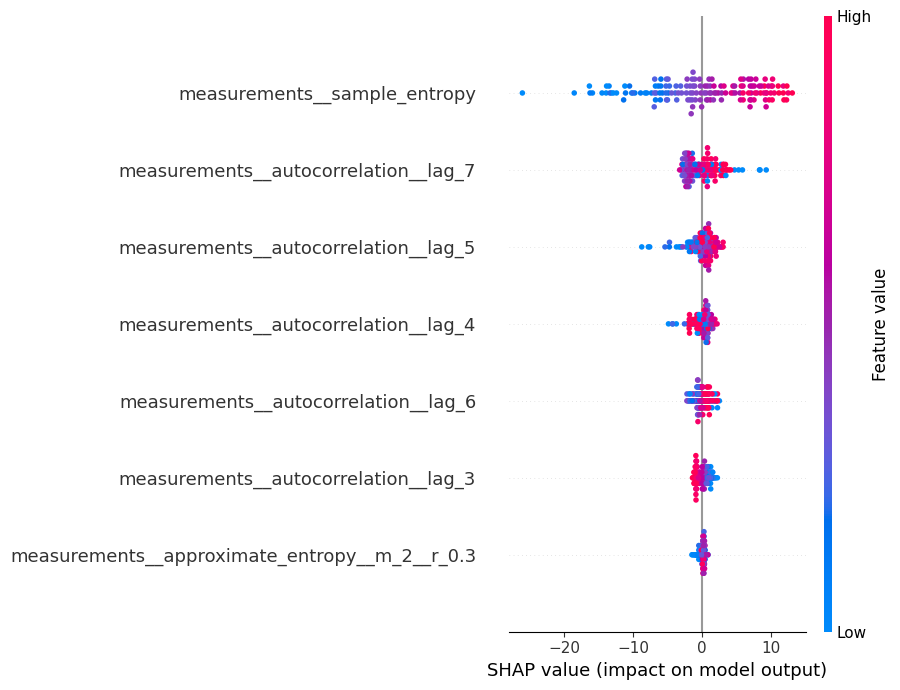

In [ ]:
shap.summary_plot(shap_values[0], data, feature_names, plot_size=(9, 7))

**Komentarz:** Wykres pokazuje, jak wartość każdej z cechy *(wyrażona kolorem)* ma wpływ na wybór lub nie-wybór *(SHAP value)* próbki do klasy 0.

Możemy np. zauważyć, że wysokie wartości cechy `measurements__sample_entropy` mają duży wpływ na wybranie próbki do klasy 0, a mniejsze wartości tej cechy będą wskazywać, że model nie będzie chciał klasyfikować danej próbki do klasy 0.

Dla innych cech te trendy nie są aż tak wyraźne, ale są nadal zauważalne (no może oprócz ostatniej cechy).

### [8.2.2] Dla klasy 1 -> napad

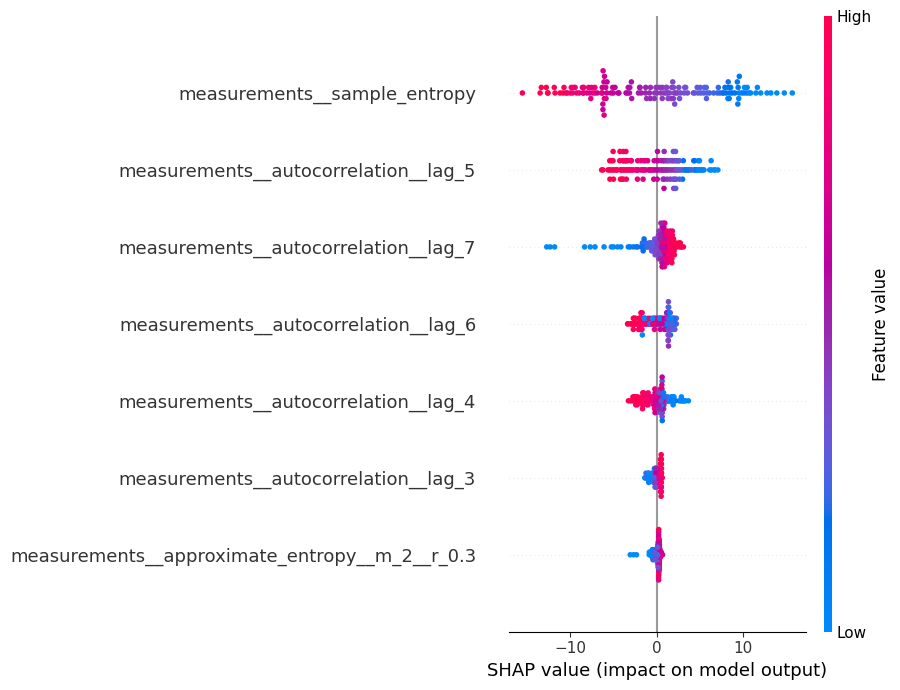

In [ ]:
shap.summary_plot(shap_values[1], data, feature_names, plot_size=(9, 7))

**Komentarz:** Tutaj możemy zauważyć odwrotny trend dla najbardziej znaczącej cechy `measurements__sample_entropy`. Niskie wartości tej cechy będą miały bardzo duży wpływ na decyzję o tym, że próbkę należy zaklasyfikować do klasy 1, a wysokie że nie chcemy tej próbki zaklasyfikować do klasy 1.

Dla pozostałych cech też są zauważalne jakieś trendy (szczególnie cech 2-3), ale przez mniejszy wpływ na model (mniejsze wartości SHAP) nie są aż tak wyraźne.

### [8.2.3] Dla klasy 2 -> międzynapadowy

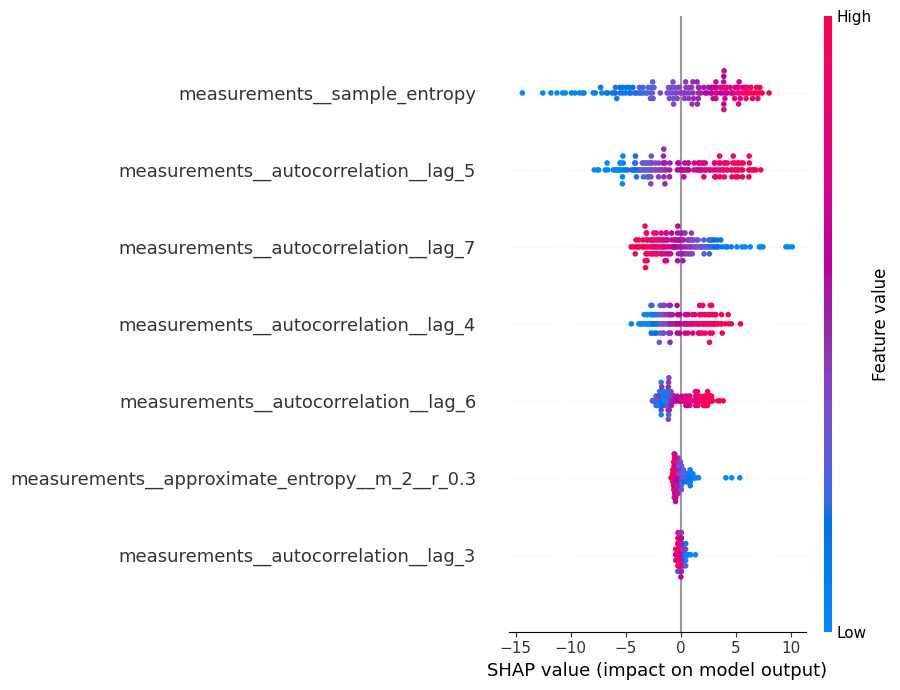

In [ ]:
shap.summary_plot(shap_values[2], data, feature_names, plot_size=(9, 7))

**Komentarz:** Ponownie obserwujemy trendy w danych, ale wykres dla klasy drugiej różni się tym, że pozostałe cechy mają znacznie większy wpływ na zaklsyfikowanie (lub nie-zaklsyfikowanie) próbki do klasy 2.

## [8.3] Analiza minimum jednej wybranej cechy dla każdej z klas

### [8.3.1] measurements__sample_entropy dla klasy 0

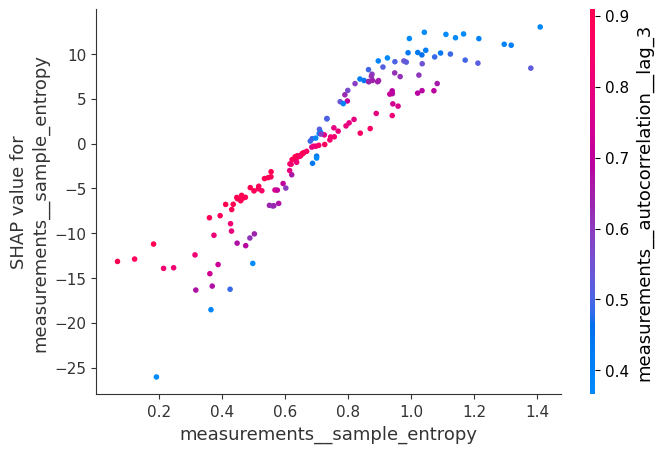

In [ ]:
shap.dependence_plot("measurements__sample_entropy", shap_values[0], data, feature_names)

**Komentarz:** Powyższy wykres wskazuje jak wartości cechy measurements__sample_entropy i wartości cechy measurements__autocorrelation__lag_3 rozkładają się względem wartości SHAP.

Można zaobserwować, że wysokie wartości sample_entropy mają duży wpływ na to, że model zaklasyfikuje próbkę do klasy 0, a niskie wartości tej cechy, że nie zaklasyfikuje tej próbki do klasy 0. Nie można jednak powiedzieć, że wartości autocorrelation__lag_3 podlegają monotonicznemu trendowi względem drugiej cechy czy wartości shap.

### [8.3.2] measurements__sample_entropy dla klasy 1

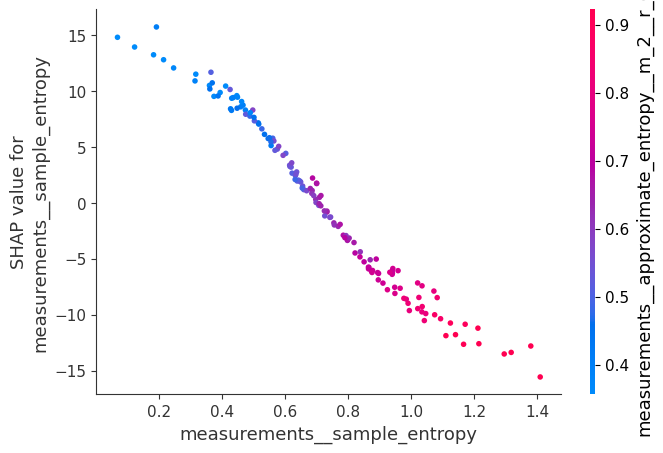

In [ ]:
shap.dependence_plot("measurements__sample_entropy", shap_values[1], data, feature_names)

**Komentarz:** Powyższy wykres wskazuje jak wartości cechy measurements__sample_entropy i wartości cechy measurements__approximate_entrupy__m_2__4_ rozkładają się względem wartości SHAP dla klasy 1.

Tutaj mamy wyraźny trend - niskie wartości cechy sample_entropy i jednocześnie niskie wartości cechy entropy__m2__r_ mają duży wpływ na to, że model zaklasyfikuje próbkę do klasy 1.

### [8.3.3] measurements__sample_entropy dla klasy 2

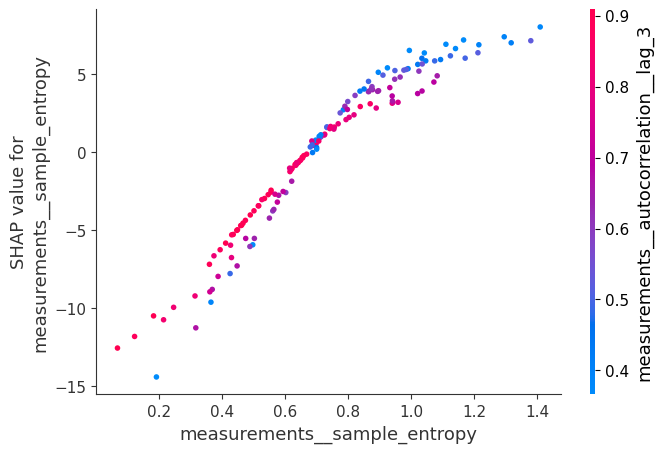

In [ ]:
shap.dependence_plot("measurements__sample_entropy", shap_values[2], data, feature_names)

**Komentarz:** Powyższy wykres wskazuje jak wartości cechy measurements__sample_entropy i ponownie wartości cechy measurements__autocorrelation__lag_3 rozkładają się względem wartości SHAP dla klasy 2.

Wykres ten wygląda podobnie jak dla klasy 0.

# [9] Ponowna klasyfikacja siecią neuronową

Tym razem spróbujemy zaklasyfikować sieć wykorzystując 3 najw

In [ ]:
df_features_3 = df_features_1[['measurements__autocorrelation__lag_5', 'measurements__sample_entropy',
                                 'measurements__autocorrelation__lag_4']]
                                #  ,'measurements__autocorrelation__lag_7'

## [9.1] Przygotowanie danych i środowiska

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

seed_value = 24

np.random.seed(seed_value)
random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True

X = df_features_3
y = df['class']

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reset indeksów
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

## [9.2] Dataloader

In [ ]:
train_dataset_4 = CancerDataset(X_train, y_train, device)
test_dataset_4 = CancerDataset(X_test, y_test, device)

# długość zbioru treningowego
print('Długość zbioru treningowego:', len(train_dataset_4))

# 0 wiersz zbioru treningowego
print('0 wiersz zbioru treningowego:', train_dataset_4[0])

Długość zbioru treningowego: 350
0 wiersz zbioru treningowego: (tensor([0.0855, 1.2914, 0.1882]), tensor(0))


In [ ]:
train_dataloader_4 = DataLoader(train_dataset_4, batch_size = 10, shuffle = True)        # shuffle =  True -> przetasowanie zbioru
test_dataloader_4 = DataLoader(test_dataset_4, batch_size = 10, shuffle = True)

## [9.3] Przygotowanie sieci

In [ ]:
class NeuralNetwork3(nn.Module):

    def __init__(self):
        super().__init__()                      # wywołanie funkcji inicjalizującej z klasy bazowej (nn.Module)

        self.input_length = 3                   # liczba cech
        self.output_length = 3                  # liczba klas - Diagnoza: M - złośliwy, B - łagodny

        self.model = nn.Sequential(
            nn.Linear(self.input_length, 25),
            nn.ReLU(),
            nn.Linear(25, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.Linear(25, self.output_length),
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:     # wykorzystanie funkcjonalności z klasy bazowej
        return self.model(input)

In [ ]:
neural_network_3 = NeuralNetwork3()

if device == "cuda":                             # erwntualne przekazanie na GPU
  neural_network.cuda()

# Kod treningowy
learning_rate = 0.0005                          # współczynnik uczenia skalujący gradient optymalizatora
epochs = 300                                   # liczba epok treningowych sieci neuronowej

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_network_3.parameters(), lr=learning_rate)
learning_rate_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min=0.001)

## [9.4] Trening sieci

In [ ]:
# Utworzenie list
training_loss_values = []
training_accuracy_values = []

validation_loss_values = []
validation_accuracy_values = []

# zdefiniowanie metryk treningowych i walidacyjnych - w naszym wypadku dokładności
training_accuracy= torchmetrics.classification.MulticlassAccuracy(num_classes=3)
validation_accuracy= torchmetrics.classification.MulticlassAccuracy(num_classes=3)

# zdefiniowanie treningu sieci
for epoch in range(epochs):                                                     # iteracja po liczbie epok
  total_loss = 0.0                                                              # zmienna do akumulacji błędu uczenia w trakcie trwania epoki (zawsze 0.0)
  total_batches = 0                                                             # zmienna początkowa sumowania minipaczek (zawsze 0)

  for idx, (train_samples, labels) in enumerate(train_dataloader_4):
    predictions = neural_network_3(train_samples)                                 # dodanie danych treningowych do sieci

    loss = criterion(predictions, labels)                                       # obliczenie funkcji kosztu

    loss.backward()                                                             # obliczenie gradientu względem każdej wagi sieci
    optimizer.step()                                                            # zaaplikowanie gradientu do wag sieci z wykorzystaniem algorytmu wstecznej propagacji błędu (wpływ wag na predykcję)
    learning_rate_scheduler.step()                                              # przeskalowanie współczynnika uczenia

# dodanie predykcji i etykiet do zdefiniowanych metryk w celu późniejszego ich obliczenia
    training_accuracy.update(predictions, labels)

    optimizer.zero_grad()                                                       # zerowanie gradientu

    total_loss += loss.item()
    total_batches += 1

  average_loss = total_loss / total_batches                                     # średni błąd uczenia

# obliczenie wcześniej zdefiniowanych metryk
  train_accuracy= training_accuracy.compute()

  print(f'Epoch [{epoch + 1}] average loss: {average_loss:.3f} Accuracy: {training_accuracy.compute():.3f}')

  training_loss_values.append(average_loss)
  training_accuracy_values.append(float(train_accuracy))

# wyłączenie obliczania gradientu przez sieć w trakcie walidacji (gradient wyznaczamy tylko podczas treningu)
  with torch.no_grad():
    val_loss = 0
    for idx, (test_samples, labels) in enumerate(test_dataloader_4):

        predictions = neural_network_3(test_samples)
        val_loss += criterion(predictions, labels).item()

        validation_accuracy.update(predictions, labels)

        total_batches += 1

    val_loss /= total_batches                                                   # błąd walidacji - jaka część próbek została błędnie sklasyfikowana
    val_accuracy= validation_accuracy.compute()

    print(f'Validation Loss: {val_loss:.3f} Accuracy: {val_accuracy:.3f}')

    validation_loss_values.append(val_loss)
    validation_accuracy_values.append(float(val_accuracy))


Epoch [1] average loss: 1.042 Accuracy: 0.412
Validation Loss: 0.290 Accuracy: 0.356
Epoch [2] average loss: 0.830 Accuracy: 0.487
Validation Loss: 0.199 Accuracy: 0.492
Epoch [3] average loss: 0.589 Accuracy: 0.533
Validation Loss: 0.169 Accuracy: 0.537
Epoch [4] average loss: 0.545 Accuracy: 0.559
Validation Loss: 0.175 Accuracy: 0.557
Epoch [5] average loss: 0.490 Accuracy: 0.584
Validation Loss: 0.142 Accuracy: 0.603
Epoch [6] average loss: 0.404 Accuracy: 0.620
Validation Loss: 0.136 Accuracy: 0.631
Epoch [7] average loss: 0.290 Accuracy: 0.660
Validation Loss: 0.108 Accuracy: 0.668
Epoch [8] average loss: 0.257 Accuracy: 0.689
Validation Loss: 0.095 Accuracy: 0.697
Epoch [9] average loss: 0.244 Accuracy: 0.714
Validation Loss: 0.096 Accuracy: 0.718
Epoch [10] average loss: 0.202 Accuracy: 0.733
Validation Loss: 0.096 Accuracy: 0.737
Epoch [11] average loss: 0.245 Accuracy: 0.747
Validation Loss: 0.092 Accuracy: 0.748
Epoch [12] average loss: 0.218 Accuracy: 0.760
Validation Loss:

## [7.5] Wyniki uczenia

### [7.5.1] Krzywe uczenia

#### [7.5.1.1] Loss values

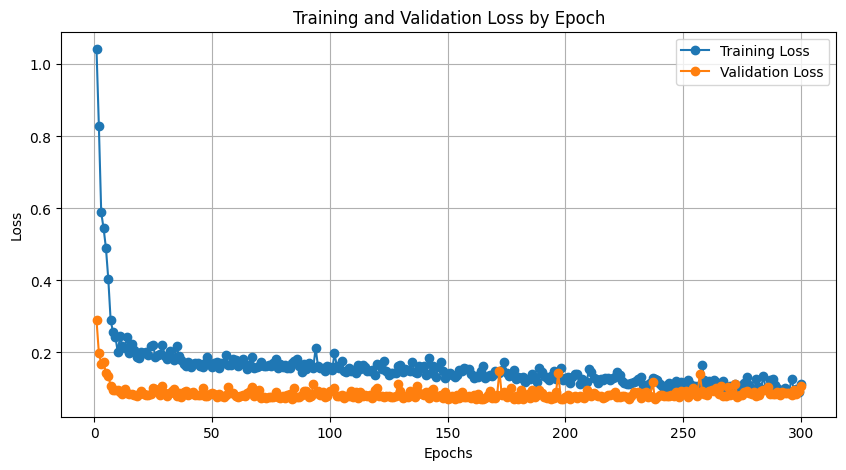

In [ ]:
# wektor epok
_epochs = list(range(1, len(training_loss_values) + 1))

# narysowanie krzywych uczenia
plt.figure(figsize=(10, 5))

# krzywa treningowa
plt.plot(_epochs, training_loss_values, label='Training Loss', marker='o')

# krzywa walidacyjna
plt.plot(_epochs, validation_loss_values, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

**Wyjaśnienie krzywych uczenia:**

**Linią niebieską** zaznaczona została krzywa uczenia **danych treningowych** podczas trwania epok uczenia (jeden punkt na wykresie odpowiada jednej wartości funkcji kosztu danych treningowych w tej epoce), która asymptotycznie zmierza do zera (minimalizacja funkcji kosztu). **Linią pomarańczową** natomiast mamy zaznaczone **dane walidacyjne**.

Strata treningowa wykazuje stały trend malejący, rozpoczynając od relatywnie wysokiej wartości i stopniowo malejąc w trakcie kolejnych epok. To wskazuje, że **model skutecznie uczy się na podstawie danych treningowych**. Jednocześnie strata walidacyjna również wykazuje trend malejący, co sugeruje, że model **dobrze generalizuje do nowych danych**.

#### [7.5.1.2] Dokładność podczas treningu

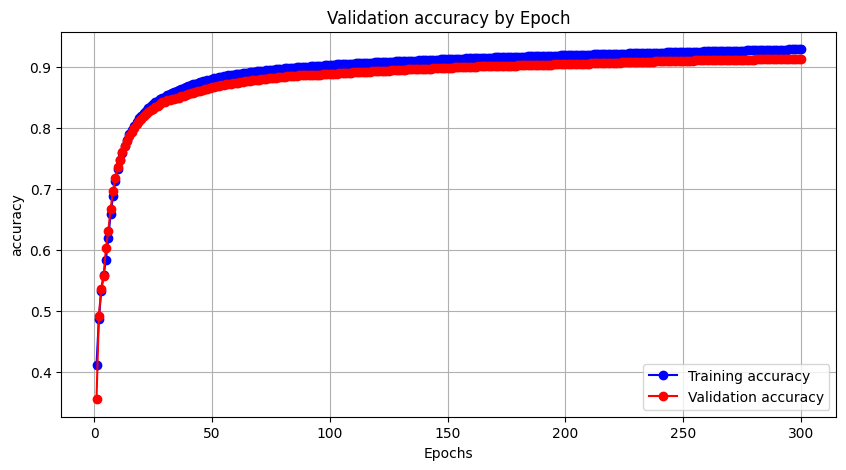

In [ ]:
_epochs = list(range(1, len(training_accuracy_values) + 1))

# Training accuracy
plt.figure(figsize=(10, 5))
plt.plot(_epochs, training_accuracy_values, label='Training accuracy', marker='o', color='blue')

# Validation accuracy
plt.plot(_epochs, validation_accuracy_values, label='Validation accuracy', marker='o', color='red')
plt.title('Validation accuracy by Epoch')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()

**KOMENTARZ:**

Model zachowuje się bardzo podobnie jak podczas treningu pierwszej sieci.

### [7.5.2] Macierz pomyłek i metryki

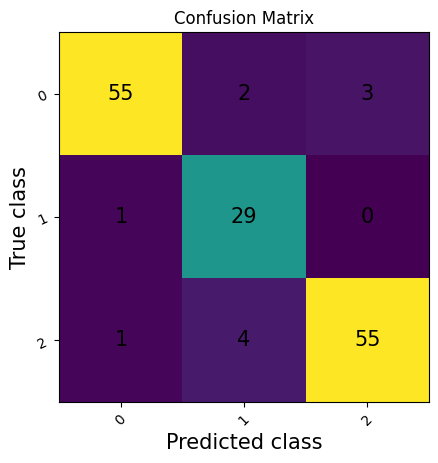

In [ ]:
# Wyznaczanie macierzy pomyłek
test_confusion_matrix = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=3)

preds = []
labels = []

with torch.no_grad():
  for idx, (test_samples, test_labels) in enumerate(test_dataset_4):
    predictions = neural_network_3(test_samples)
    predictions = predictions.argmax(dim=0).unsqueeze(0)
    test_labels = test_labels.unsqueeze(0)
    test_confusion_matrix.update(predictions, test_labels)

    preds.extend(predictions.tolist())
    labels.extend(test_labels.tolist())

fig_1, ax_1 = test_confusion_matrix.plot()

ax_1.set_title(f"Confusion Matrix")
fig_1.show()

In [ ]:
# metryki
print(classification_report(preds, labels))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        57
           1       0.97      0.83      0.89        35
           2       0.92      0.95      0.93        58

    accuracy                           0.93       150
   macro avg       0.93      0.91      0.92       150
weighted avg       0.93      0.93      0.93       150



**KOMENTARZ:**

Mimo wykorzystania mniejszej liczby cech, udało nam się poprawić wyniki klasyfikacji. W tym przypadku 3 (a były 4) sygnały międzynapadowezostały sklasyfikowane jako normalne. Ale tym razem, zamiast 8 sygnałów napadowych zaklasyfikowanych jako międzynapadowe, mamy tylko 4. W klasyfikacji sygnałów normalnych bez zmian.

# [10] Wnioski

W tym projekcie wykazano, że można zmniejszyć wymiarowośc danych wykorzystując wielorakie metody. Przeprowadzono redukcję z wykorzystaniem algorytmu FRESH, RFE, korelacji między zmiennymi, algorytmem losów losowych a na koniec z algorytmem KernelExplainer z biblioteki shap.

Przeprowadzono wstępną klasyfikację za pomocą sieci neuronowej na podstawie siedmiu cech, po czym wybrano trzy z nich które miały największe znaczenie za pomocą algorytmu shap.

Ostatecznie, zmniejszono wymiarowość z 783 cech do zaledwie 3 z nich, przeprowadzono kolejną klasyfikację za pomocą sieci neuronowej (z dopasowanymi hiperparametrami), uzyskując lepsze wyniki niż dla pierwszej sieci.

---

Zmniejszanie wymiarowości danych jest kluczowym krokiem w analizie danych, szczególnie gdy mamy do czynienia z dużą ilością zmiennych. Redukcja wymiarów może przynieść wiele korzyści, takich jak **eliminacja zbędnych informacji, poprawa wydajności obliczeniowej, a także zmniejszenie ryzyka przeuczenia modeli.** Poprzez zastosowanie odpowiednich technik możliwe jest skoncentrowanie się na istotnych aspektach danych, co ułatwia interpretację wyników analiz i przyczynia się do efektywniejszego modelowania.

W rezultacie, zmniejszenie wymiarowości stanowi skuteczną strategię optymalizacji procesu analizy danych, prowadząc do bardziej zwięzłych, a jednocześnie reprezentatywnych wyników.
